In [1]:
from preprocess import Preprocessor

import ml_inference
from ml_inference import BaselineRegressor, AutoRegressor

import pandas as pd
import seaborn as sns

from dask import delayed
from dask.distributed import Client
# see https://github.com/dask/distributed/issues/4168
import multiprocessing.popen_spawn_win32

INFILE = '../data/pennycook_et_al_study2_clean.csv'
client = Client(n_workers=4)
pd.options.mode.chained_assignment = None

In [2]:
df = pd.read_csv(INFILE)
X, treat, y = df.drop(columns='Diff'), df.Treatment, df.Diff
df.head()

,SharingType_1,SharingType_2,SharingType_3,SharingType_4,SharingType_6,SharingType_5,SocialMedia_1,SocialMedia_2,SocialMedia_3,SocialMedia_4,...,Education,Income,English,Partisan,Social_Conserv,Economic_Conserv,Treatment,Diff,Party,POTUS2016
0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,17.0,9.0,1.0,3.0,1.0,2.0,1.0,-0.200000,Democrat,Clinton
1,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,19.0,3.0,1.0,5.0,4.0,4.0,0.0,-0.666667,Republican,Trump
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,16.0,7.0,1.0,3.0,2.0,2.0,0.0,0.000000,Independent,Clinton
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,13.0,4.0,1.0,2.0,4.0,4.0,0.0,0.000000,Democrat,Clinton
4,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,14.0,6.0,1.0,1.0,5.0,5.0,0.0,0.200000,Democrat,Clinton


In [3]:
from sklearn.linear_model import LinearRegression


class BaselineTreatmentRegressor(LinearRegression):
    def __init__(self, treatment_var):
        self.treatment_var = treatment_var
        super().__init__()
        
    def fit(self, X, y, sample_weight=None):
        return super().fit(self.transform(X), y, sample_weight)
        
    def predict(self, X):
        return super().predict(self.transform(X))
    
    def transform(self, X):
        return (
            X[self.treatment_var].to_frame() if isinstance(X, pd.DataFrame)
            else X[:, self.treatment_var].reshape(-1, 1)
        )

In [4]:
def get_treatment_idx(treatment_var, X):
    if not isinstance(X, pd.DataFrame):
         X = pd.DataFrame(X)
    return pd.get_dummies(X[treatment_var])

In [5]:
def treatment_split(treatment_var, X, vectors=[], rm_treatment=True):
    def split_vectors(idx):
        if not vectors:
            return split_vector(X, idx)
        return [split_vector(v, idx) for v in [X]+vectors]
    
    def split_vector(v, idx):
        return (
            v[idx==1].reset_index(drop=True) if isinstance(v, (pd.DataFrame, pd.Series))
            else v[idx]
        )
    
    if not isinstance(vectors, list):
        vectors = [vectors]
    treatment_idx = get_treatment_idx(treatment_var, X)
    if rm_treatment:
        if isinstance(X, pd.DataFrame):
            # treat_var is a column name
            X = X.drop(columns=treatment_var)
        else:
            # treat_var is a column index
            X = np.delete(X, treatment_var, axis=1)
    return {key: split_vectors(idx) for key, idx in treatment_idx.iteritems()}

In [6]:
import numpy as np
from sklearn.base import RegressorMixin
from sklearn.ensemble._base import _BaseHeterogeneousEnsemble
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score

class TreatmentRegressor(RegressorMixin, _BaseHeterogeneousEnsemble):
    def __init__(self, estimators, treatment_var, scoring=r2_score):
        self.estimators = estimators
        self.treatment_arms = [treatment for treatment, _ in estimators]
        self.treatment_var = treatment_var
        self.scoring = scoring
        
    def fit(self, X, y):
        def fit_weights(X, y):
            X_t = self.transform(X)
            self.constrained_weight_ = fit_constrained_weight(X_t, y)
            resid = y - (X_t * self.constrained_weight_).sum(axis=1)
            split = treatment_split(self.treatment_var, X, [X_t, resid])
            self.weight_ = pd.DataFrame(
                {key: fit_unconstrained_weight(X, resid) 
                for key, (_, X, resid) in split.items()}
            )[self.treatment_arms]
            
        def fit_constrained_weight(X, y):
            # constrain weights to sum to 1
            reference = X.columns[0]
            y -= X[reference]
            X = X.apply(lambda x: x-X[reference]).drop(columns=reference)
            reg = LinearRegression(fit_intercept=False).fit(X, y)
            return pd.Series(
                index=self.treatment_arms,
                data=np.insert(reg.coef_, 0, 1-reg.coef_.sum())
            )
        
        def fit_unconstrained_weight(X, y):
            # residual weights sum to 0
            # INCREASE THE WEIGHT UNTIL ALL COEFS ARE BETWEEN 0 AND 1
            # make this the lower bound
            reg = Ridge(10, fit_intercept=False).fit(X, y)
            return (reg.coef_ - reg.coef_.mean()) + self.constrained_weight_

        X, y = X.reset_index(drop=True), y.reset_index(drop=True)
        # store means and stds for each treatment arm
        self.mean_ = y.groupby(X[self.treatment_var]).mean()
        self.std_ = y.groupby(X[self.treatment_var]).std()
        # standardize y for each condition
        treatment_idx = self.get_treatment_idx(X)
        y = (y - treatment_idx @ self.mean_) / (treatment_idx @ self.std_)
        # train models for each treatment arm
        split = treatment_split(self.treatment_var, X, y)
        for treatment, est in self.estimators:
            X_, y_ = split[treatment]
            est.fit(X_, y_)
        # fit weights
        fit_weights(X, y)
        return self
    
    def get_treatment_idx(self, X):
        idx = get_treatment_idx(self.treatment_var, X)
        return idx[self.treatment_arms].reset_index(drop=True)

    def predict(self, X, return_constrained=False):
        def compute_prediction(weight):
            y_pred = (weight * X).sum(axis=1)
            return y_pred * (treatment_idx @ self.std_) + treatment_idx @ self.mean_
        
        treatment_idx = self.get_treatment_idx(X)
        X = self.transform(X)
        y_pred_uc = compute_prediction(weight=treatment_idx @ self.weight_.T)
        if return_constrained:
            y_pred_c = compute_prediction(weight=self.constrained_weight_)
            return y_pred_uc, y_pred_c
        return y_pred_uc
    
    def predict_effect(self, X, control_val=0, treatment_val=1):
        def unnormalize(df, value):
            df[value] = df[value] * self.std_[value] + self.mean_[value]
            
        X = self.transform(X)
        y_pred = X @ self.weight_[[control_val, treatment_val]]
        unnormalize(y_pred, control_val)
        unnormalize(y_pred, treatment_val)
        return y_pred[treatment_val] - y_pred[control_val]
        
    def transform(self, X):
        X = (
            X.drop(columns=self.treatment_var) if isinstance(X, pd.DataFrame) 
            else np.delete(X, self.treatment_var, axis=1)
        )
        return pd.DataFrame({
            treatment: est.predict(X) for treatment, est in self.estimators
        }).reset_index()[self.treatment_arms]
    
    def score(self, X, y, return_constrained=False):
        y_pred = self.predict(X, return_constrained=return_constrained)
        if return_constrained:
            return self.scoring(y, y_pred[0]), self.scoring(y, y_pred[1])
        return self.scoring(y, y_pred)
    
    def get_params(self, deep=False):
        out = super().get_params(deep=deep)
        out.update(dict(
            treatment_var=self.treatment_var,
            scoring=self.scoring
        ))
        return out

def explain_effect(reg, X, nsamples=1000, local=True, scoring=r2_score, scoring_params={}):
    if local:
        g = lambda effect_pred: effect_pred
    else:
        effect = reg.predict_effect(X)
        g = lambda effect_pred: scoring(effect, effect_pred, **scoring_params)
    explainer = gshap.KernelExplainer(reg.predict_effect, X, g)
    gshap_values = explainer.gshap_values(X, nsamples=nsamples)
    if local:
        if isinstance(X, pd.DataFrame):
            return pd.DataFrame(columns=X.columns, data=gshap_values.T)
        return gshap_values.T
    gshap_values /= gshap_values.sum()
    if isinstance(X, pd.DataFrame):
        return pd.DataFrame({'Feature': X.columns, 'G-SHAP': gshap_values})
    return gshap_values

In [ ]:
# def train_autoreg(treatment, X, y):
#     print('\nTuning model for treatment arm', treatment)
#     return AutoRegressor(preprocess=Preprocessor(X), n_jobs=-1).tune(X, y, n_iter=2**5)

# split = treatment_split('Treatment', X, y)
# models = {key: train_autoreg(key, X, y) for key, (X, y) in split.items()}

In [ ]:
# reg = TreatmentRegressor(models, 'Treatment')
# reg.fit(X, y)

In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR

def make_svr_pipeline():
    return make_pipeline(
        Preprocessor(),
        SVR()
    )

estimators = [
    (0, make_svr_pipeline()),
    (1, make_svr_pipeline())
]
reg = TreatmentRegressor(estimators, 'Treatment')
reg.fit(X, y)

TreatmentRegressor(estimators=[(0,
                                Pipeline(steps=[('preprocessor',
                                                 Preprocessor()),
                                                ('svr', SVR())])),
                               (1,
                                Pipeline(steps=[('preprocessor',
                                                 Preprocessor()),
                                                ('svr', SVR())]))],
                   treatment_var='Treatment')

count    835.000000
mean      -0.161164
std        0.023534
min       -0.368101
25%       -0.176530
50%       -0.157671
75%       -0.143537
max       -0.115540
dtype: float64

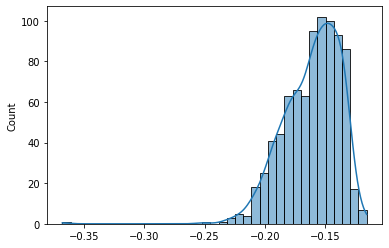

In [8]:
effect = reg.predict_effect(X)
sns.histplot(effect, kde=True)
effect.describe()

[Text(0.5, 15.0, 'Treatment group'),
 Text(33.0, 0.5, 'Weight on treatment-specific model')]

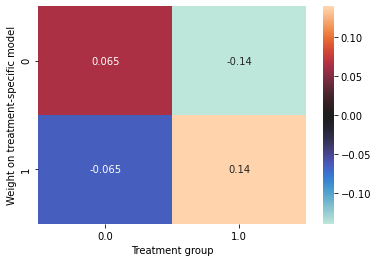

In [9]:
weight_df = reg.weight_.copy()
weight_df = weight_df.apply(lambda x: x-reg.constrained_weight_)
ax = sns.heatmap(weight_df, center=0, annot=True)
ax.set(xlabel='Treatment group', ylabel='Weight on treatment-specific model')

In [10]:
from ml_inference.test import moderation_test

In [24]:
%%time

score_df, tstat, pvalue = moderation_test(reg, X, y, parallel=True)
score_df

Wall time: 16 s


,Constrained,Unconstrained
0,0.025846,0.022299
1,0.033654,0.030027
2,0.030878,0.026829
3,0.046308,0.043109
4,0.030612,0.028293
5,0.048918,0.046035
6,0.038817,0.035074
7,0.047500,0.044421
8,0.045801,0.042929
9,0.043242,0.038458


In [25]:
tstat, pvalue

(-15.450611942646661, 0.9999999563923403)

<AxesSubplot:xlabel='Model', ylabel='Cross validation score'>

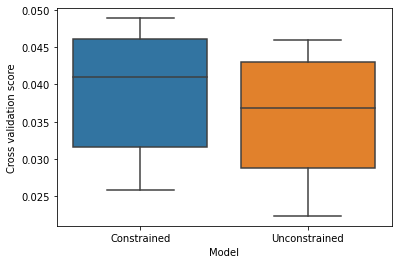

In [26]:
from ml_inference.test import gen_score_plot

gen_score_plot(score_df)

In [27]:
client.close()